# Bonus2: Build a Supervised Autoencoder.

### Name: Ryan Adoni



PCA and the standard autoencoder are unsupervised dimensionality reduction methods, and their learned features are not discriminative. If you build a classifier upon the low-dimenional features extracted by PCA and autoencoder, you will find the classification accuracy very poor.

Linear discriminant analysis (LDA) is a traditionally supervised dimensionality reduction method for learning low-dimensional features which are highly discriminative. Likewise, can we extend autoencoder to supervised leanring?



**You are required to build and train a supervised autoencoder look like the following.** You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


## 0. You will do the following:

1. Read and run my code to train a standard dense autoencoder.

2. Build and train a supervised autoencoder, visual the low-dim features and the reconstructions, and evaluate whether the learned low-dim features are discriminative.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    
    
4. Upload this .HTML file to your Google Drive, Dropbox, or Github repo.

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus2/Bonus2.html


## 1. Data preparation

### 1.1. Load data


In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28*28).astype('float32') / 255.
x_test = x_test.reshape(10000, 28*28).astype('float32') / 255.

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
11501568/11490434 [==============================] - 5s 0us/step
Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
import numpy

def to_one_hot(y, num_class=10):
    results = numpy.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (60000, 10)
Shape of y_test_vec: (10000, 10)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 60K training samples to 2 sets:
* a training set containing 10K samples;
* a validation set containing 50K samples. (You can use only 10K to save time.)


In [3]:
rand_indices = numpy.random.permutation(60000)
train_indices = rand_indices[0:10000]
valid_indices = rand_indices[10000:20000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (10000, 784)
Shape of y_tr: (10000, 10)
Shape of x_val: (10000, 784)
Shape of y_val: (10000, 10)


## 2. Build an unsupervised  autoencoder and tune its hyper-parameters

1. Build a dense autoencoder model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
    
3. Try to achieve a validation loss as low as possible.
4. Evaluate the model on the test set.
5. Visualize the low-dim features and reconstructions.

### 2.1. Build the model

In [4]:
from keras.layers import Dense, Input
from keras import models

input_img = Input(shape=(784,), name='input_img')

encode1 = Dense(128, activation='relu', name='encode1')(input_img)
encode2 = Dense(32, activation='relu', name='encode2')(encode1)
encode3 = Dense(8, activation='relu', name='encode3')(encode2)
bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)
decode1 = Dense(8, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(32, activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='relu', name='decode4')(decode3)

ae = models.Model(input_img, decode4)

ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
_________________________________________________________________
decode1 (Dense)              (None, 8)                 24        
_________________________________________________________________
decode2 (Dense)              (None, 32)                288   

In [6]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(ae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=ae, show_shapes=False,
    to_file='unsupervised_ae.pdf'
)

# you can find the file "unsupervised_ae.pdf" in the current directory.

### 2.2. Train the model and tune the hyper-parameters

In [9]:
from keras import optimizers

learning_rate = 1E-3 # to be tuned!

ae.compile(loss='mean_squared_error',
           optimizer=optimizers.RMSprop(learning_rate=learning_rate)) # got a warning that "lr" was deprecated and to use "learning_rate" so I changed it

In [10]:
history = ae.fit(x_tr, x_tr, 
                 batch_size=128, 
                 epochs=100, 
                 validation_data=(x_val, x_val))

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpdp_vy8ph.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpdp_vy8ph.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
79/79 [==============================] - 20s 18ms/step - loss: 0.0869 - val_loss: 0.0825
Epoch 2/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0827 - val_loss: 0.0824
Epoch 3/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0815 - val_loss: 0.0798
Epoch 4/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0795 - val_loss: 0.076

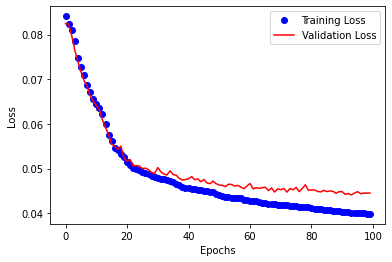

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.3. Visualize the reconstructed test images

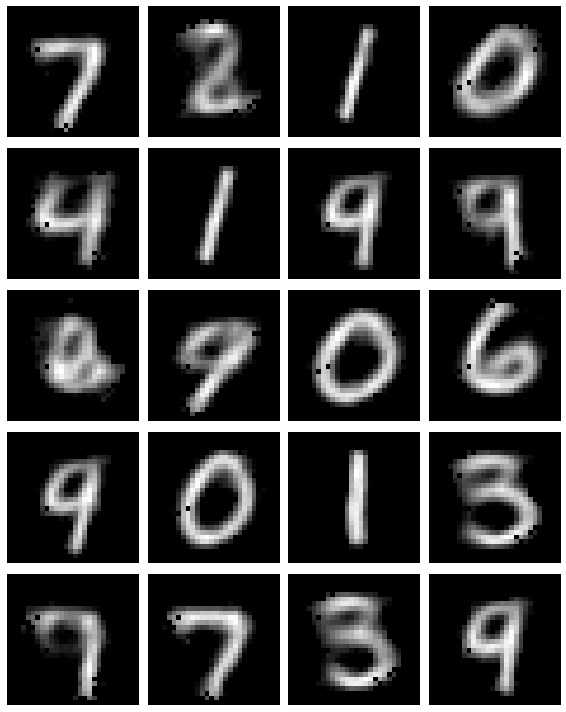

In [13]:
ae_output = ae.predict(x_test).reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = ae_output
fname = 'reconstruct_ae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, numpy.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 2.4. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [14]:
loss = ae.evaluate(x_test, x_test)
print('loss = ' + str(loss))

313/313 [==============================] - 0s 1ms/step - loss: 0.0448
loss = 0.04475177079439163


### 2.5. Visualize the low-dimensional features

In [15]:
# build the encoder network
ae_encoder = models.Model(input_img, bottleneck)
ae_encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
Total params: 104,890
Trainable params: 104,890
Non-trainable params: 0
_________________________________________________________________


In [16]:
# extract low-dimensional features from the test data
encoded_test = ae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

Shape of encoded_test: (10000, 2)


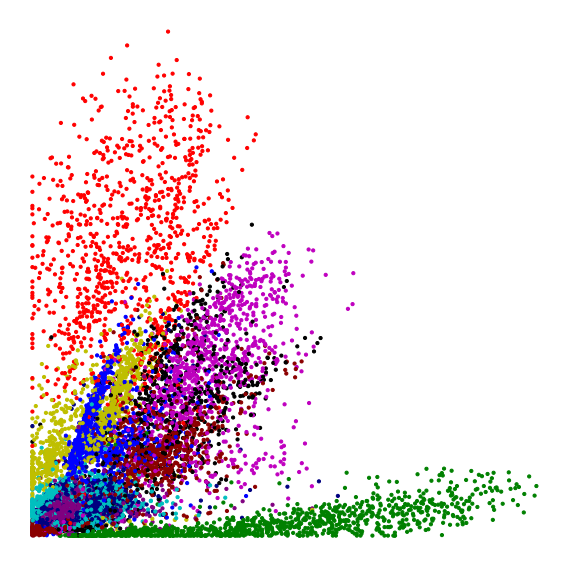

In [17]:
colors = numpy.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'ae_code.pdf'
plt.savefig(fname)

#### Remark:

Judging from the visualization, the low-dim features seems not discriminative, as 2D features from different classes are mixed. Let quantatively find out whether they are discriminative.

## 3. Are the learned low-dim features discriminative?

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the test set.

In [18]:
# extract the 2D features from the training, validation, and test samples
f_tr = ae_encoder.predict(x_tr)
f_val = ae_encoder.predict(x_val)
f_te = ae_encoder.predict(x_test)

print('Shape of f_tr: ' + str(f_tr.shape))
print('Shape of f_te: ' + str(f_te.shape))

Shape of f_tr: (10000, 2)
Shape of f_te: (10000, 2)


In [19]:
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               384       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [20]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

C:\Users\Ryan Adoni\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/30
313/313 [==============================] - 2s 3ms/step - loss: 2.1702 - acc: 0.2090 - val_loss: 1.8035 - val_acc: 0.3076
Epoch 2/30
313/313 [==============================] - 1s 2ms/step - loss: 1.7508 - acc: 0.3186 - val_loss: 1.6719 - val_acc: 0.3109
Epoch 3/30
313/313 [==============================] - 1s 2ms/step - loss: 1.6484 - acc: 0.3154 - val_loss: 1.5884 - val_acc: 0.3506
Epoch 4/30
313/313 [==============================] - 1s 2ms/step - loss: 1.5773 - acc: 0.3740 - val_loss: 1.5320 - val_acc: 0.4058
Epoch 5/30
313/313 [==============================] - 1s 2ms/step - loss: 1.5087 - acc: 0.4346 - val_loss: 1.4815 - val_acc: 0.4629
Epoch 6/30
313/313 [==============================] - 1s 2ms/step - loss: 1.4666 - acc: 0.4745 - val_loss: 1.4352

### Conclusion

Using the 2D features, the validation accuracy is 60~70%. Recall that using the original data, the accuracy is about 98%. Obviously, the 2D features are not very discriminative.

We are going to build a supervised autoencode model for learning low-dimensional discriminative features.

## 4. Build a supervised autoencoder model


**You are required to build and train a supervised autoencoder look like the following.** (Not necessary the same.) You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


### 4.1. Build the network

In [151]:
# build the supervised autoencoder network
from keras.layers import Dense, Input, BatchNormalization, Dropout, Activation
from keras import models

input_img = Input(shape=(784,), name='input_img')



# code from above for my own reference.  Initially copying this from 2.1 above to create the model to start and I will then add improvements
# encode1 = Dense(128, activation='relu', name='encode1')(input_img)
# encode2 = Dense(32, activation='relu', name='encode2')(encode1)
# encode3 = Dense(8, activation='relu', name='encode3')(encode2)
# bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)
# decode1 = Dense(8, activation='relu', name='decode1')(bottleneck)
# decode2 = Dense(32, activation='relu', name='decode2')(decode1)
# decode3 = Dense(128, activation='relu', name='decode3')(decode2)
# decode4 = Dense(784, activation='relu', name='decode4')(decode3)
# ae = models.Model(input_img, decode4)

# used the same architecture stated above
# encoder network
encode1 = Dense(128, activation='relu', name='encode1')(input_img) # <add a dense layer taking input_img as input>
encode2 = Dense(32, activation='relu', name='encode2')(encode1)
encode3 = Dense(8, activation='relu', name='encode3')(encode2)

# The width of the bottleneck layer must be exactly 2.
bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3) # <the output of encoder network>

# decoder network
decode1 = Dense(8, activation='relu', name='decode1')(bottleneck) # <add a dense layer taking bottleneck as input>
decode2 = Dense(32, activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2) #  tried dropout here.  Gives weird results
decode4 = Dense(784, activation='relu', name='decode4')(decode3) # <the output of decoder network>

# build a classifier upon the bottleneck layer
#<Add more dense layers and regularizations...>

# add batch regularizations to the layers
classifier1 = Dense(16, activation='relu', name='classifier1')(bottleneck) # <add a dense layer taking bottleneck as input>
classifier2 = Dense(32, name='classifier2')(Activation('relu')(BatchNormalization()(classifier1)))
classifier3 = Activation('relu')(BatchNormalization()(Dense(32, name='classifier3')(Activation('relu')(BatchNormalization()(classifier2))))) # testing with more layers
dropout1 = Dropout(0.3)(classifier3) # dropout
classifier4 = Dense(32, name='classifier4')(classifier3) # testing with more layers
classifier5 = Dense(10, activation='softmax', name='classifier5')(Activation('relu')(BatchNormalization()(classifier4))) # <the output of classifier network>

In [152]:
# connect the input and the two outputs
sae = models.Model(input_img, [decode4, classifier5])

sae.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 784)]        0                                            
__________________________________________________________________________________________________
encode1 (Dense)                 (None, 128)          100480      input_img[0][0]                  
__________________________________________________________________________________________________
encode2 (Dense)                 (None, 32)           4128        encode1[0][0]                    
__________________________________________________________________________________________________
encode3 (Dense)                 (None, 8)            264         encode2[0][0]                    
___________________________________________________________________________________________

In [153]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(sae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=sae, show_shapes=False,
    to_file='supervised_ae.pdf'
)

# you can find the file "supervised_ae.pdf" in the current directory.

### 4.2. Train the new model and tune the hyper-parameters

The new model has multiple output. Thus we specify **multiple** loss functions and their weights. 

In [154]:
from keras import optimizers

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1, 0.5], # to be tuned
            optimizer=optimizers.RMSprop(learning_rate=1E-3)) # got a warning that "lr" was deprecated and to use "learning_rate" so I changed it

history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=100, 
                  validation_data=(x_val, [x_val, y_val]))

_decode4_loss: 0.0577 - val_classifier5_loss: 0.4771
Epoch 6/100
313/313 [==============================] - 2s 5ms/step - loss: 0.2559 - decode4_loss: 0.0578 - classifier5_loss: 0.3961 - val_loss: 0.2311 - val_decode4_loss: 0.0568 - val_classifier5_loss: 0.3485
Epoch 7/100
313/313 [==============================] - 2s 5ms/step - loss: 0.2195 - decode4_loss: 0.0570 - classifier5_loss: 0.3250 - val_loss: 0.2375 - val_decode4_loss: 0.0568 - val_classifier5_loss: 0.3613
Epoch 8/100
313/313 [==============================] - 2s 5ms/step - loss: 0.2048 - decode4_loss: 0.0570 - classifier5_loss: 0.2956 - val_loss: 0.2600 - val_decode4_loss: 0.0564 - val_classifier5_loss: 0.4071
Epoch 9/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1891 - decode4_loss: 0.0566 - classifier5_loss: 0.2650 - val_loss: 0.2204 - val_decode4_loss: 0.0562 - val_classifier5_loss: 0.3284
Epoch 10/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1850 - decode4_loss: 0.0562 - cla

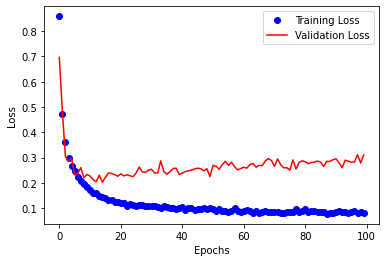

In [156]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Question

Do you think overfitting is happening? If yes, what can you do? Please make necessary changes to the supervised autoencoder network structure.

This was overfitting pretty badly when I first started, but this looks better I think.  The validation loss doesn't get as low as the training, but it still increases slowly over time.  I found a higher dropout rate makes the graph look very strange.

**Failing to add proper regularization will lose 1~2 scores.**

### 4.3. Visualize the reconstructed test images

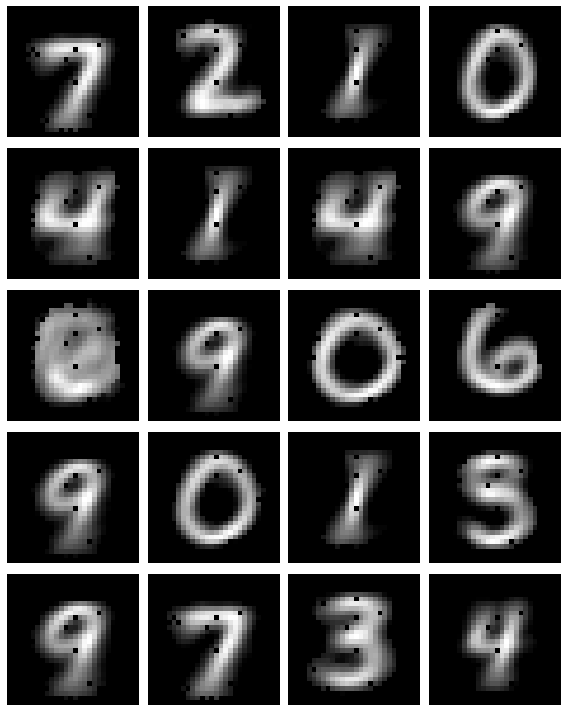

In [157]:
sae_output = sae.predict(x_test)[0].reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = sae_output
fname = 'reconstruct_sae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, numpy.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 4.4. Visualize the low-dimensional features

In [121]:
# build the encoder model
sae_encoder = models.Model(input_img, bottleneck)
sae_encoder.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
Total params: 104,890
Trainable params: 104,890
Non-trainable params: 0
_________________________________________________________________


Shape of encoded_test: (10000, 2)


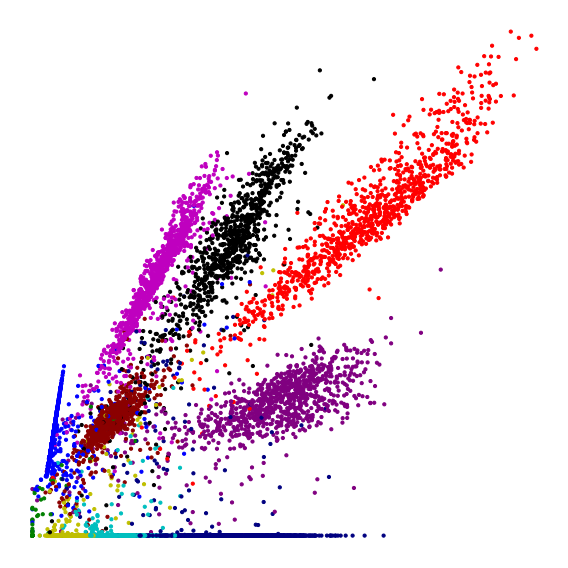

In [122]:
# extract test features
encoded_test = sae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

colors = numpy.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'sae_code.pdf'
plt.savefig(fname)

### 4.5. Are the learned low-dim features discriminative?

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the validation and test set.


In [105]:
# extract 2D features from the training, validation, and test samples
f_tr = sae_encoder.predict(x_tr)
f_val = sae_encoder.predict(x_val)
f_te = sae_encoder.predict(x_test)

In [47]:
# build a classifier which takes the 2D features as input
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

# copied from section 2.5 above.  Sam classifier framework
hidden1 = Dense(128, activation='relu')(input_feat) # <build a classifier which takes input_feat as input>
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2) # <output of the classifier network>

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [49]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1E-4), # # got a warning that "lr" was deprecated and to use "learning_rate" so I changed it
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 [==============================] - 2s 3ms/step - loss: 0.0515 - acc: 0.9903 - val_loss: 0.5731 - val_acc: 0.9237
Epoch 2/30
313/313 [==============================] - 1s 2ms/step - loss: 0.0556 - acc: 0.9897 - val_loss: 0.5771 - val_acc: 0.9234
Epoch 3/30
313/313 [==============================] - 1s 2ms/step - loss: 0.0474 - acc: 0.9917 - val_loss: 0.5829 - val_acc: 0.9225
Epoch 4/30
313/313 [==============================] - 1s 2ms/step - loss: 0.0525 - acc: 0.9902 - val_loss: 0.5867 - val_acc: 0.9232
Epoch 5/30
313/313 [==============================] - 1s 2ms/step - loss: 0.0571 - acc: 0.9871 - val_loss: 0.5914 - val_acc: 0.9224
Epoch 6/30
313/313 [==============================] - 1s 2ms/step - loss: 0.0454 - acc: 0.9908 - val_loss: 0.5979 - val_acc: 0.9213
Epoch 7/30
313/313 [==============================] - 1s 2ms/step - loss: 0.0638 - acc: 0.9888 - val_loss: 0.5975 - val_acc: 0.9236
Epoch 8/30
313/313 [==============================] - 1s 2ms/step - loss: 0.

#### Remark:

The validation accuracy must be above 90%. It means the low-dim features learned by the supervised autoencoder are very effective.

In [55]:
# evaluate your model on the never-seen-before test data
# write your code here:

# looked at HM 4 for guidance on this
loss_and_acc = classifier.evaluate(f_te, y_test_vec) # f_te not x_test
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 0s 836us/step - loss: 0.5309 - acc: 0.9298
loss = 0.53094482421875
accuracy = 0.9297999739646912
